## World map with L2 difference between human preferences and gpt4 preferences
- Also contains the creation of model_preferences_by_country_gpt4.csv

In [1]:
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
gpt4=pd.read_csv("./cluster_data/model_preferences_by_lang_gpt4.csv")
humans=pd.read_csv("./cluster_data/human_preferences_by_country.csv")
population=pd.read_csv("./cluster_data/proportions_population.csv")

In [3]:
gpt4=pd.melt(gpt4,id_vars='criterion',value_name='estimate',var_name='Languages')

In [4]:
## rescale both quantities to the interval [0,1]
gpt4['estimate']=gpt4['estimate']/100

humans.Estimates=(humans.Estimates+1)/2

In [5]:
## compute gpt4 preference by country
country_lang=population.merge(gpt4,on=['Languages'])
country_lang['weighted_estimate']=(country_lang.percentage*country_lang.estimate)/100
country_lang=country_lang.groupby(['Country','ISO3','criterion']).agg({'weighted_estimate':np.sum}).reset_index()

In [6]:
humans=humans.rename(columns={'Country':'ISO3','Label':'criterion','Estimates':'human_estimate'})
humans=humans.loc[humans.criterion.isin(['Gender', 'Fitness',
       'Social Status', 'Age', 'No. Characters', 'Species'])]

In [7]:
map_rep={'Gender':'Gender_Female', 'Fitness':'Fitness_Fit',
       'Social Status':'SocialValue_High', 'Age':'Age_Young', 'No. Characters':'Utilitarianism_More', 'Species':'Species_Humans'}

In [8]:
humans.criterion=humans.criterion.replace(map_rep)

humans_gpt=humans.merge(country_lang,on=['ISO3','criterion'])

humans_gpt['sqe']=(((humans_gpt.weighted_estimate)-(humans_gpt.human_estimate))**2)

df_agg=humans_gpt.groupby(['Country','ISO3']).agg({'sqe':np.sum}).reset_index()

population=population.loc[:,['ISO3','Value']].drop_duplicates()

df_agg=df_agg.merge(population,on='ISO3')

df_agg['l2_distance']=df_agg['sqe']**0.5

In [9]:
## create file model_preferences_by_country_gpt4.csv
gpt4_pivoted=country_lang.pivot_table(index=['criterion'],columns=['ISO3'],values=['weighted_estimate']).reset_index()
distances=df_agg.rename(columns={'l2_distance':'l2_distance_with_human'}).loc[:,['ISO3','l2_distance_with_human']].sort_values('ISO3').set_index('ISO3').T.reset_index().rename(columns={'index':'criterion'})
gpt4_pivoted=gpt4_pivoted.droplevel(0, axis=1)
gpt4_pivoted=gpt4_pivoted.rename(columns={'':'criterion'})

distances_save=pd.concat([gpt4_pivoted,distances])
distances_save=round(distances_save,6)

In [10]:
distances_save.to_csv("./cluster_data/model_preferences_by_country_gpt4.csv",index=False)

In [11]:
df_agg.sqe.describe()

count    160.000000
mean       0.493039
std        0.543756
min        0.030230
25%        0.187263
50%        0.240420
75%        0.612328
max        3.167870
Name: sqe, dtype: float64

In [12]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world=world.loc[world.continent!='Antarctica',:]

/tmp/ipykernel_20709/3620744348.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


In [13]:
df_agg=df_agg.loc[df_agg.ISO3.isin(world.iso_a3.unique())].reset_index(drop=True)

In [14]:
df_agg.l2_distance.quantile([0.25,0.5,0.75,1])

0.25    0.445032
0.50    0.491879
0.75    0.797343
1.00    1.779851
Name: l2_distance, dtype: float64

/tmp/ipykernel_13841/3154208422.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.6,ticks=tick_positions)


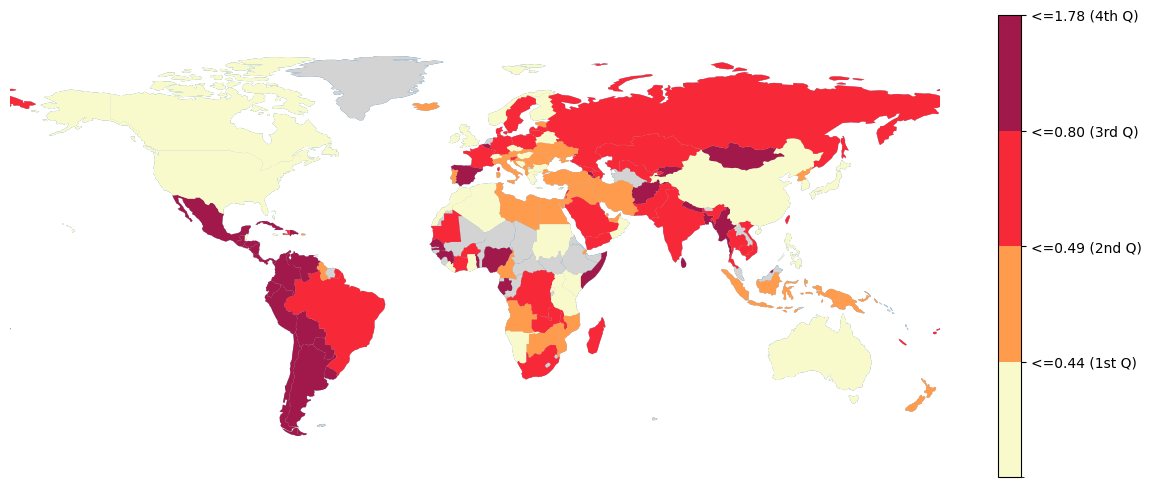

In [15]:



ax = world.plot(figsize=(15, 10))
world.plot(color='#D3D3D3',edgecolor='none',ax=ax)
for i,d in df_agg.iterrows():
    if d['l2_distance']<=df_agg.l2_distance.quantile(0.25):
        world[world.iso_a3 == d['ISO3']].plot(color='#F8FACC',ax=ax)
    elif (d['l2_distance']<=df_agg.l2_distance.quantile(0.5)) and (d['sqe']>df_agg.sqe.quantile(0.25)):
        world[world.iso_a3 == d['ISO3']].plot(color='#FF9B4D',ax=ax)
    elif (d['l2_distance']<=df_agg.l2_distance.quantile(0.75)) and (d['sqe']>df_agg.sqe.quantile(0.5)):
        world[world.iso_a3 == d['ISO3']].plot(color='#F72837',ax=ax)
    elif  (d['l2_distance']>df_agg.l2_distance.quantile(0.75)):
        world[world.iso_a3 == d['ISO3']].plot(color='#A1194A',ax=ax)
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.margins(0)
#plt.subplots_adjust(right=0.15)  # Increase space on the right side for the colorbar
#cbar_ax = ax.add_axes([0.99, 0.18, 0.02, 0.7])  # [left, bottom, width, height]
#cbar = plt.colorbar(ax, cax=cbar_ax)
# Define your custom colors
colors = ['#F8FACC', '#FF9B4D', '#F72837', '#A1194A']
labels = ['<=0.44 (1st Q)', '<=0.49 (2nd Q)', '<=0.80 (3rd Q)', '<=1.78 (4th Q)']
# Create a colormap using the custom colors
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(labels) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
#cbar_ax = plt.add_axes([0.99, 0.18, 0.02, 0.7])  # [left, bottom, width, height]
tick_positions = np.arange(len(labels)) + 1
cbar = plt.colorbar(sm, shrink=0.6,ticks=tick_positions)
cbar.set_ticklabels(labels)
plt.savefig('./cluster_data/fig_map_l2.pdf',dpi=300,bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


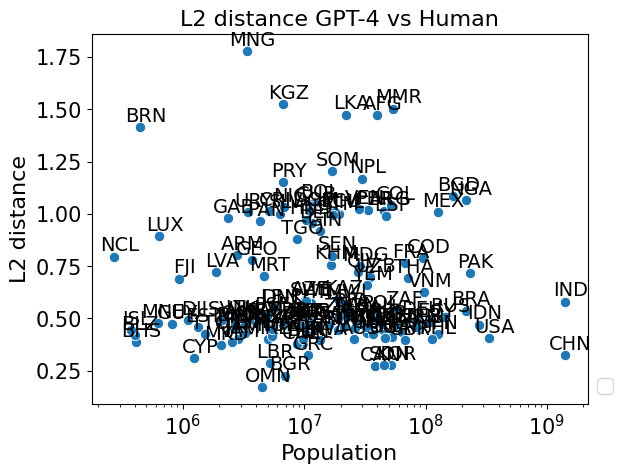

In [16]:
ax=sns.scatterplot(data=df_agg,x='Value',y='l2_distance',s=55)
#plt.yscale('log')
plt.xscale('log')
plt.title('L2 distance GPT-4 vs Human',size=16)
plt.ylabel('L2 distance',size=16)
plt.xlabel('Population',size=16)
#lgd=sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
lgd = ax.legend(loc=3, bbox_to_anchor=(1,0),fontsize=14)
for i in range(df_agg.shape[0]):
    plt.annotate(df_agg.ISO3.values[i], (df_agg['Value'].values[i], df_agg.l2_distance.values[i]), textcoords="offset points", xytext=(4,4), ha='center',fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
#plt.savefig('mse_scatter2_log.png', transparent=True,bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.savefig('./cluster_data/fig_scatter_l2.pdf',dpi=300,bbox_extra_artists=(lgd,),bbox_inches='tight')